In [5]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import seaborn as sns
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import norm
from scipy import signal
from matplotlib import gridspec
import matplotlib 
from os import listdir
from os.path import isfile, join
import statsmodels.api as sm
from scipy.stats import fisher_exact,chi2_contingency
from scipy.signal import savgol_filter

In [6]:
mypath='C:/Users/liang/Documents/Thesis/LinearGraph/D/HMaze/'
stateNames=['A1','A2','A3','A4','A5']
beh = pd.DataFrame()
BlockLearning=pd.DataFrame()
    
for ii,f in enumerate(listdir(mypath)):
    
    beh_temp = pd.read_csv(join(mypath, f), sep=",")
#     beh_temp = pd.read_csv('C:/Users/liang/Documents/Thesis/LinearGraph/B/NewVersion/LinearBridge_2023_07_13__13_33_30.beh.txt', sep=",")
    beh_temp.reset_index(drop=True, inplace=True)
    beh_temp.insert(loc = 0,
          column = 'SessionNum',
          value = ii)
    beh = pd.concat([beh,beh_temp])
    
beh=beh[beh.GoalBlockNum>0]

In [2]:
# specify the state-state transition matrix in the task
# here action is negligible, only need to choose the correct state
# A1 - A2 - A3 - A4 - A5
#           CA
#           C
#           CB
# B1 - B2 - B3 - B4 - B5

T=np.zeros((13,13)) #A1-A5, B1-B5, CA,C,CB
T[0:5,0:5] = np.eye(5,k=1)+np.eye(5,k=-1)
T[5:10,5:10] = np.eye(5,k=1)+np.eye(5,k=-1)
T[10:,10:] = np.eye(3,k=1)+np.eye(3,k=-1)
T[2,10] = 1
T[10,2] = 1
T[7,12] = 1
T[12,7] = 1

In [165]:
def softmax_policy(Q, beta=3):
    """
    Creates a softmax policy based on a given Q-function and inverse temperature beta.
    
    Args:
    
        Q: A array of the state value
        beta: inverse temperature, specify the level of exploit v.s. explore, greater value means exploit
        
    Returns:
        The probabilities for each state to be chosen. 
    
    """
    
    if len(Q) == 1:
        prob = [1]
    else:
        exp_Q_beta = np.exp(beta * np.array(Q))
        prob = exp_Q_beta / np.sum(exp_Q_beta)
    
    choice = np.random.choice(len(Q), p=prob)
    
    return choice, prob

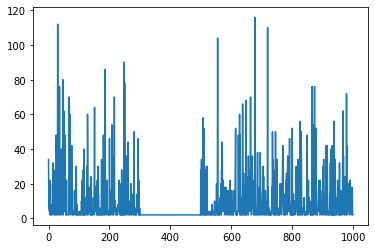

In [92]:
beh, episode_length = DP_simulation(T,beta=5,gamma=0.3)
plt.close('all')
plt.plot(episode_length)

Text(0.5, 1.0, 'Goal=B5')

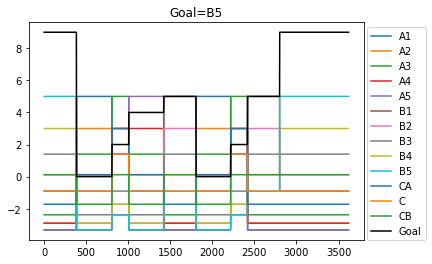

In [80]:
plt.close('all')
states = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','CA','C','CB']
for s in range(len(states)):
    plt.plot(beh[:,s+5],label=states[s])
plt.plot(beh[:,2],'k-',label='Goal')
plt.legend(bbox_to_anchor=(0.7, .5, 0.5, 0.5))
plt.title('Goal='+states[int(beh[0,2])])

In [102]:
beh, _ = DP_simulation(T, gamma=0.5, beta=6)

In [103]:
bnds = ((0, 1), (0, None))
res = minimize(DP_fit, (0.5, 3), bounds=bnds)
res.x

array([0.49646767, 6.1868124 ])

In [97]:
def DP_simulation(T, gamma=0.8, beta=1, theta=0.001):
    """
    Dynamic programming to calculate the state value
    
    Args:
        T: State transition matrix
        gamma: Temporal discount factor. Float between 0 and 1.
        beta: Inverse temperature. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
        
    Goals = [0,2,4,5,7,9]
    Starts = [2,7,11]
    
    total_block = 10
    block_size = 100
    total_episode_num = 0
    
    episode_lengths = np.zeros(total_block*block_size)
    beh_history = []
    
    for block_num in range(total_block):
        
        Q = np.zeros(len(T))
        goal = np.random.choice(Goals)
        Q[goal] = 5
        
        while True:
    
            for current_state in range(len(T)):

                if current_state!=goal:
                    sucessors = np.where(T[current_state,:]==1)[0]
                    delta[current_state] = -1 + gamma*Q[sucessors].max() - Q[current_state]
                    Q[current_state] = -1 + gamma*Q[sucessors].max() 

            if np.abs(delta).max() < theta:
                break

        
        for episode_num in range(block_size):
                                    
            if goal%5==2:
                current_state = 11
            else:
                current_state = np.random.choice(Starts)
            
            for t in itertools.count():

                sucessors = np.where(T[current_state,:]==1)[0]
                choice_ind,choice_prob = softmax_policy(Q[sucessors],beta=beta)
                next_state = sucessors[choice_ind]

                # Update statistics
                episode_lengths[total_episode_num] = t+1   
                trial_info = np.concatenate([np.array([block_num,episode_num,goal,current_state,next_state]),Q]).reshape(1,-1)
                if len(beh_history)==0:
                    beh_history = trial_info
                else:
                    beh_history = np.concatenate([beh_history,trial_info])
                
                if next_state==goal:
                    break

                current_state = next_state
                
            total_episode_num+=1
            
    beh_history = pd.DataFrame(beh_history,columns=['BlockNum','EpisodeNum','Goal','Current','Next',
                                                    'A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','CA','C','CB'])
    
    return beh_history, episode_lengths

In [ ]:
V_next = -1 + gamma*Q[sucessors].max()
S_next = Q[sucessors].argmax()

In [5]:
a = np.array([2,2,3,4])
a.argmin()

0

In [ ]:
# breadth first search + expand all states
# a more complex version: only expand unvisited states


d = 0
planned_current_state = current_state

while True:

    sucessors = np.where(T[planned_current_state,:]==1)[0]



    delta[current_state] = -1 + gamma*Q[sucessors].max()
    Q[current_state] = -1 + gamma*Q[sucessors].max() 

    if planned_next_state == goal:
        break

    d += 1
    if d == depth:
        break


In [97]:
def DLP_simulation(T, depth=2, gamma=0.8, beta=1, theta=0.001):
    """
    Depth-limited planning, plan certain depths then use habit value
    
    Args:
        T: State transition matrix
        gamma: Temporal discount factor. Float between 0 and 1.
        beta: Inverse temperature. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
        
    Goals = [0,2,4,5,7,9]
    Starts = [2,7,11]
    
    total_block = 10
    block_size = 100
    total_episode_num = 0
    
    episode_lengths = np.zeros(total_block*block_size)
    beh_history = []
    
    
    for block_num in range(total_block):
        
        Q = np.zeros(len(T))
        goal = np.random.choice(Goals)
        Q[goal] = 5
        
        
        for episode_num in range(block_size):
            
                                    
            if goal%5==2:
                current_state = 11
            else:
                current_state = np.random.choice(Starts)

            
            for t in itertools.count():
                



                sucessors = np.where(T[current_state,:]==1)[0]
                choice_ind,choice_prob = softmax_policy(Q[sucessors],beta=beta)
                next_state = sucessors[choice_ind]

                # Update statistics
                episode_lengths[total_episode_num] = t+1   
                trial_info = np.concatenate([np.array([block_num,episode_num,goal,current_state,next_state]),Q]).reshape(1,-1)
                if len(beh_history)==0:
                    beh_history = trial_info
                else:
                    beh_history = np.concatenate([beh_history,trial_info])
                
                if next_state==goal:
                    break

                current_state = next_state
                
            total_episode_num+=1
            
    beh_history = pd.DataFrame(beh_history,columns=['BlockNum','EpisodeNum','Goal','Current','Next',
                                                    'A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','CA','C','CB'])
    
    return beh_history, episode_lengths

In [99]:
def DP_fit(params, data=beh, T=T, theta=0.001):
    """
    Dynamic programming to calculate the state value
    
    Args:
        T: State transition matrix
        gamma: Temporal discount factor. Float between 0 and 1.
        beta: Inverse temperature. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
        
    gamma = params[0]
    beta = params[1]
    minusLL = 0
        
    for block_num in range(int(beh.BlockNum.values[-1])):
        
        block_perf = beh[beh.BlockNum==block_num]
        goal = block_perf.Goal.values[0]
        Q[int(goal)] = 5
        
        
        while True:
            
            for current_state in range(len(T)):

                if current_state!=goal:
                    sucessors = np.where(T[current_state,:]==1)[0]
                    delta[current_state] = -1 + gamma*Q[sucessors].max() - Q[current_state]
                    Q[current_state] = -1 + gamma*Q[sucessors].max() 

            if np.abs(delta).max() < theta:
                break
        
        
        for episode_num in range(int(block_perf.EpisodeNum.values[-1])):
                        
            episode_perf = block_perf[block_perf.EpisodeNum==episode_num]
            
            for t in range(len(episode_perf)):
                
                current_state = episode_perf.Current.values[t]
                sucessors = np.where(T[int(current_state),:]==1)[0]
                choice_ind,choice_prob = softmax_policy(Q[sucessors],beta=beta)
                
                next_state = episode_perf.Next.values[t]
                minusLL = minusLL-np.log(choice_prob[np.where(sucessors==next_state)[0][0]])
                
    
    return minusLL

In [30]:
def TDlamda_simulation(T, Q, gamma=0.8, alpha=0.5, beta=3, lamda=0.8):
    """
    Q-Learning algorithm: Off-policy TD lamda control, following a softmax policy
    
    Args:
        T: state transition matrix
        Q: value function
        gamma: temporal discount factor.
        alpha: TD learning rate.
        beta: Inverse temperature. Float between 0 and 1.
        delta: how fast eligibility trace decay
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
        
    Goals = [0,2,4,5,7,9]
    Starts = [2,7,11]
    E = np.zeros(len(T))    # eligibility trace
    
    total_block = 10
    block_size = 100
    total_episode_num = 0 
    
    episode_lengths = np.zeros(total_block*block_size)
    beh_history = []
    
    for block_num in range(total_block):
        
        goal = np.random.choice(Goals)
        Q[goal] = 5
        
        for episode_num in range(block_size):
                        
            if goal%5==2:
                current_state = 11
            else:
                current_state = np.random.choice(Starts)
            
            for t in itertools.count():
                
                # choose an action based on the current value function
                sucessors = np.where(T[current_state,:]==1)[0]
                choice_ind,choice_prob = softmax_policy(Q[sucessors],beta=beta)
                next_state = sucessors[choice_ind]
                
                # update the value with eligibility trace
                delta=-1+gamma*Q[next_state]-Q[current_state]
                E[current_state]=(1-alpha)*E[current_state]+1
                for s in range(len(E)):
                    Q[s]=Q[s]+alpha*delta*E[s]
                    E[s]=gamma*lamda*E[s]


                # Update statistics
                episode_lengths[total_episode_num] = t   
                trial_info = np.concatenate([np.array([block_num,episode_num,goal,current_state,next_state]),Q]).reshape(1,-1)
                if len(beh_history)==0:
                    beh_history = trial_info
                else:
                    beh_history = np.concatenate([beh_history,trial_info])
                
                if next_state==goal:
                    break

                current_state = next_state
                
            total_episode_num+=1
            
    beh_history = pd.DataFrame(beh_history,columns=['BlockNum','EpisodeNum','Goal','Current','Next',
                                                    'A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','CA','C','CB'])
    
    return beh_history, episode_lengths

In [204]:
def TDlamda_fit(params, data=beh, T=T):
    """
    Q-Learning algorithm: Off-policy TD lamda control, following a softmax policy
    
    Args:
        data: animal's actual behavior
        T: state transition matrix
        gamma: temporal discount factor.
        alpha: TD learning rate.
        beta: Inverse temperature. Float between 0 and 1.
        delta: how fast eligibility trace decay
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    gamma = params[0]
    alpha = params[1]
    beta = params[2]
    lamda = params[3]
    forget = params[4]
    
    E = np.zeros(len(T))    # eligibility trace
    Q = np.zeros(len(T))    # value function
    minusLL = 0
        
    for ses_num in beh.SessionNum.unique():
        
        ses_perf = beh[beh.SessionNum==ses_num]
        
        for block_num in ses_perf.GoalBlockNum.unique():

            block_perf = ses_perf[ses_perf.GoalBlockNum==block_num]
            goal = block_perf.Goal.values[0]

            for episode_num in block_perf.EpisodeNum.unique():

                episode_perf = block_perf[block_perf.EpisodeNum==episode_num]

                for t in range(len(episode_perf)):

                    current_state = episode_perf.CurrentState.values[t]-1
                    sucessors = np.where(T[int(current_state),:]==1)[0]
                    choice_ind,choice_prob = softmax_policy(Q[sucessors],beta=beta)

                    next_state = episode_perf.ChosenState.values[t]-1
                    minusLL = minusLL-np.log(choice_prob[np.where(sucessors==next_state)[0][0]])

                    if next_state==goal-1:
                        Q[int(next_state)]=5

                    delta=-1+gamma*Q[int(next_state)]-Q[int(current_state)]

                    
                    # eligibility trace
                    E[int(current_state)]=(1-alpha)*E[int(current_state)]+1
                    for s in range(len(E)):
                        if s==current_state:
                            Q[s]=Q[s]+alpha*delta*E[s]
                        else:
                            Q[s]=Q[s]*forget+alpha*delta*E[s]
                        E[s]=gamma*lamda*E[s]
    
    return minusLL

In [205]:
def TDlamda_fit_beh(params, data=beh, T=T):
    """
    Q-Learning algorithm: Off-policy TD lamda control, following a softmax policy
    
    Args:
        data: animal's actual behavior
        T: state transition matrix
        gamma: temporal discount factor.
        alpha: TD learning rate.
        beta: Inverse temperature. Float between 0 and 1.
        delta: how fast eligibility trace decay
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    gamma = params[0]
    alpha = params[1]
    beta = params[2]
    lamda = params[3]
    forget = params[4]
    
    E = np.zeros(len(T))    # eligibility trace
    Q = np.zeros(len(T))    # value function
    Q_history=[]
    C_history=[]
        
    for ses_num in beh.SessionNum.unique():
        
        ses_perf = beh[beh.SessionNum==ses_num]
        
        for block_num in ses_perf.GoalBlockNum.unique():

            block_perf = ses_perf[ses_perf.GoalBlockNum==block_num]
            goal = block_perf.Goal.values[0]

            for episode_num in block_perf.EpisodeNum.unique():

                episode_perf = block_perf[block_perf.EpisodeNum==episode_num]

                for t in range(len(episode_perf)):
                                        
                    Q_history.append(np.array(Q))

                    current_state = episode_perf.CurrentState.values[t]-1
                    sucessors = np.where(T[int(current_state),:]==1)[0]
                    choice_ind,choice_prob = softmax_policy(Q[sucessors],beta=beta)
                    C_history.append(sucessors[choice_ind]+1)
                    
                    next_state = episode_perf.ChosenState.values[t]-1
                    
                    if next_state==goal-1:
                        Q[int(next_state)]=5

                    delta=-1+gamma*Q[int(next_state)]-Q[int(current_state)]

                    
                    # eligibility trace
                    E[int(current_state)]=(1-alpha)*E[int(current_state)]+1
                    for s in range(len(E)):
                        if s==current_state:
                            Q[s]=Q[s]+alpha*delta*E[s]
                        else:
                            Q[s]=Q[s]*forget+alpha*delta*E[s]
                        E[s]=gamma*lamda*E[s]

    
    return np.array(C_history), np.array(Q_history)

In [208]:
C_history,Q_history = TDlamda_fit_beh(res.x, data=beh, T=T)

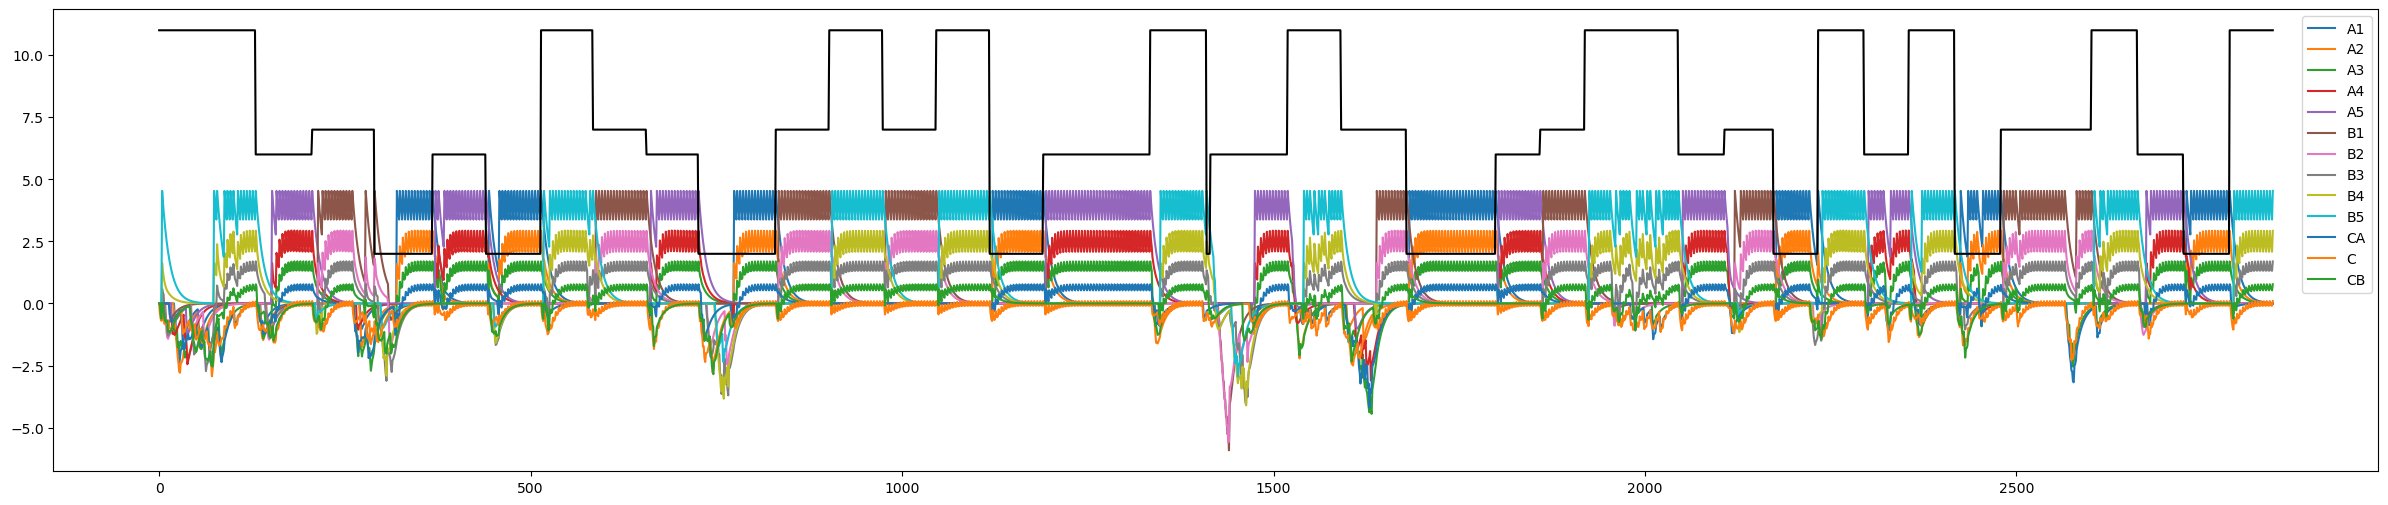

In [209]:
plt.close('all')
plt.figure(figsize=(30,6),facecolor=(1, 1, 1))
plt.plot(Q_history)
plt.legend(['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','CA','C','CB'])
plt.plot(beh.Goal.values+1,'k')

In [206]:
bnds = ((0, 1), (0, 1), (0, 10), (0, 1), (0,1))
res = minimize(TDlamda_fit, (0.5, 0.5, 3, 0.5, 0.9), bounds=bnds)
res.x

array([1.        , 0.40717968, 1.69835872, 0.5926275 , 0.90671426])